In [38]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch.nn.functional as F

In [11]:
dataset = MNIST(root = 'data/', download = True, transform = transforms.ToTensor())

In [12]:
len(dataset)

60000

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


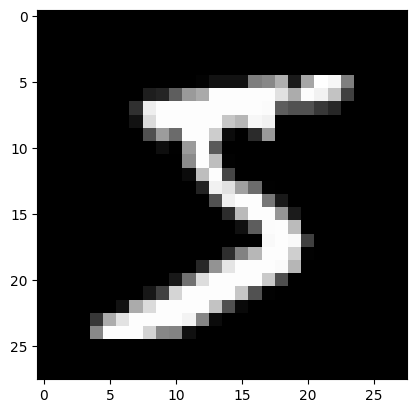

In [22]:
plt.imshow(img_tensor[0], cmap='gray');

In [23]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [25]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [26]:
import torch.nn as nn

input_size = 28*28
num_classes = 10 #no. of digits from 0-9

# Logistic regression model
model = nn.Linear(input_size, num_classes)

In [30]:
print(model.weight)

Parameter containing:
tensor([[ 0.0278,  0.0248, -0.0318,  ...,  0.0046,  0.0133,  0.0165],
        [-0.0229,  0.0133, -0.0342,  ...,  0.0038,  0.0046,  0.0300],
        [-0.0002, -0.0259,  0.0273,  ..., -0.0224, -0.0047,  0.0080],
        ...,
        [-0.0195,  0.0122,  0.0028,  ..., -0.0238, -0.0152, -0.0335],
        [ 0.0098,  0.0312,  0.0112,  ..., -0.0056,  0.0064,  0.0142],
        [-0.0145,  0.0098, -0.0193,  ..., -0.0353, -0.0102, -0.0166]],
       requires_grad=True)


In [32]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [33]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [34]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [47]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

In [48]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.33331036567688, 'val_acc': 0.08613528311252594}

In [52]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8596, val_acc: 0.8319
Epoch [1], val_loss: 0.8280, val_acc: 0.8362
Epoch [2], val_loss: 0.8004, val_acc: 0.8384
Epoch [3], val_loss: 0.7761, val_acc: 0.8404
Epoch [4], val_loss: 0.7544, val_acc: 0.8437


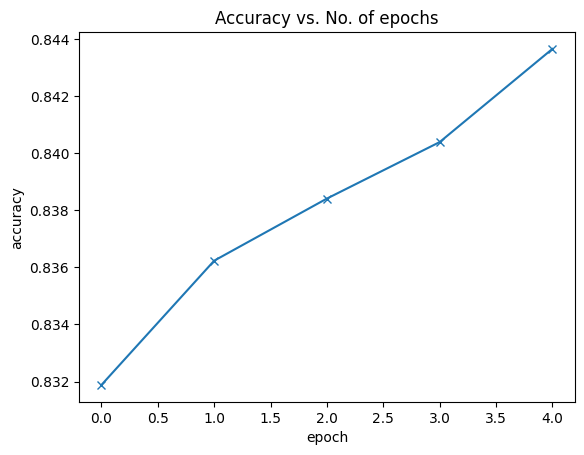

In [54]:
#history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history1]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [55]:
torch.save(model.state_dict(), 'mnist-logistic-jovian.pth')

In [56]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0158, -0.0092,  0.0242,  ...,  0.0024,  0.0213,  0.0323],
                      [ 0.0148, -0.0067, -0.0220,  ...,  0.0089,  0.0041,  0.0144],
                      [-0.0267,  0.0132,  0.0318,  ...,  0.0113, -0.0189,  0.0165],
                      ...,
                      [ 0.0052, -0.0289, -0.0193,  ...,  0.0175,  0.0337, -0.0226],
                      [ 0.0078, -0.0171,  0.0152,  ..., -0.0224,  0.0355,  0.0131],
                      [ 0.0114, -0.0280, -0.0190,  ...,  0.0086, -0.0009,  0.0007]])),
             ('linear.bias',
              tensor([-0.0650,  0.1047, -0.0501, -0.0198,  0.0141,  0.0011, -0.0050,  0.0580,
                      -0.0798,  0.0082]))])